In [67]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.offline as po
import seaborn as sns
import matplotlib.pyplot as plt 
import os 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import ElasticNetCV


This notebook contains exploration of all the raw data and will conclude with proposals for data transformations and wrangling.

In [43]:
df = pd.read_csv('_raw/case1Data.txt')

In [44]:
# NA values are by default strings, since there is a space in front
df = df.replace(' NaN', np.nan)

# ensure numeric dtype

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass


In [45]:
# only 4 out of 100 cols are complete.
# the rest contain NA's and require a decision on how to handle it
df.loc[:,df.isna().sum(axis=0) == 0].columns

Index(['y', ' C_ 2', ' C_ 3', ' C_ 4', ' C_ 5'], dtype='object')

In [46]:
# isolate targets from the design matrix
y = df['y']
X = df.iloc[:,1::]


In [47]:
# for convenience, fix the column naming
# with no spaces

X.columns = [name.replace(' ', '') for name in X.columns]
X.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,NaN,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,10.303557,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,12.057741,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,7.182760,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,9.933879,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H


Text(0, 0.5, '#NA per column')

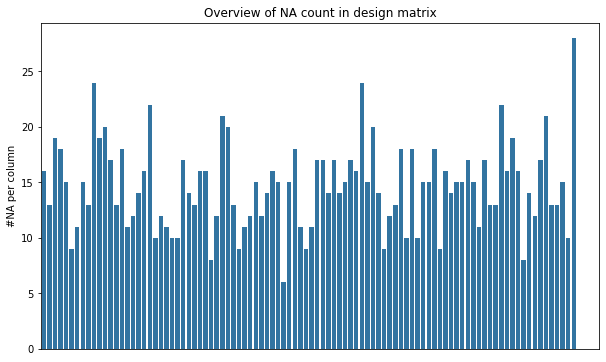

In [48]:
# what to do about the NA's?
nas = X.isna().sum(axis=0)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(
    
    x=nas.index,
    y= nas.values,
    color='tab:blue',

)
plt.title('Overview of NA count in design matrix')
plt.xticks([])
plt.ylabel('#NA per column')

For any given column 10-25% of data is missing. In total, ~14% of data is missing. In this case, the choice of how to fill NA's will have a significant impact on the models performance. The first, simplest choice is to impute the columns mean or a majority label.

## Use column mean or majority for NA

In [49]:
# look into the categorical attributes
cat_cols = [col for col in X.columns if 'C' in col]
for col in cat_cols:
    print(X[col].value_counts())
    print('-'*10)

 J    23
 G    18
 H    12
 I    11
 K     8
Name: C_1, dtype: int64
----------
 H    100
Name: C_2, dtype: int64
----------
 J    26
 G    21
 K    21
 I    16
 H    16
Name: C_3, dtype: int64
----------
 K    24
 G    24
 J    20
 I    20
 H    12
Name: C_4, dtype: int64
----------
 K    24
 I    24
 J    19
 H    17
 G    16
Name: C_5, dtype: int64
----------


C_1 is the only one missing lables. C_2 is redundant as it only contains a single lable (H), so should not be included in the model.

In [50]:
# fill missing data

X_mean = X.copy()
for col in X_mean.columns:
    if 'x' in col: 
        # impute mean for continuous
        X_mean[col] = X_mean[col].replace(np.nan, X_mean[col].mean())
    else:
        # impute majority group for categorical
        X_mean[col] = X_mean[col].replace(np.nan, X_mean[col].value_counts().index[0]) 

## Scale and encode attribute data

In [51]:
# drop C_2 from cat_cols
cat_cols.remove('C_2')

In [52]:
X_cont = X_mean.loc[:,[col for col in X_mean.columns if 'x' in col]]
X_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_cont), columns=X_cont.columns)
X_scaled = pd.concat([X_cont,pd.get_dummies(X_mean[cat_cols])], axis=1)

In [53]:
X_scaled

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,C_4_ G,C_4_ H,C_4_ I,C_4_ J,C_4_ K,C_5_ G,C_5_ H,C_5_ I,C_5_ J,C_5_ K
0,1.208626e-15,0.000000,2.013601e+00,1.090246,5.439675e-01,1.238584,3.842614e-01,0.319772,3.322680e-01,6.545004e-16,...,0,0,0,0,1,0,0,0,1,0
1,6.983175e-01,-0.144005,5.227784e-01,0.078762,1.958793e+00,1.949235,-4.450169e-01,0.000000,9.135559e-01,4.184132e-01,...,1,0,0,0,0,1,0,0,0,0
2,-1.902184e+00,-0.074197,1.307966e-01,0.134436,3.885536e-02,0.350106,5.242694e-01,-0.327886,9.387376e-01,1.064744e+00,...,0,1,0,0,0,1,0,0,0,0
3,2.634566e+00,-0.604329,9.089690e-02,1.086510,1.923120e+00,-1.015659,-1.976761e+00,1.106461,-1.127875e+00,-7.314475e-01,...,0,0,0,0,1,1,0,0,0,0
4,4.245698e-01,0.000000,2.145321e+00,0.616044,3.625686e-01,-0.765803,-5.951899e-01,0.000000,-9.559252e-01,2.822050e-01,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.275262e-01,1.171230,6.444114e-01,-0.627415,1.374446e-15,-0.329834,-3.387880e-15,0.153868,-6.778659e-16,1.426949e+00,...,1,0,0,0,0,1,0,0,0,0
96,-1.124048e+00,-0.946810,-7.600873e-01,-0.986996,-8.727656e-01,-0.074669,-1.275224e+00,-2.475271,-3.922758e-01,-1.029843e+00,...,0,0,1,0,0,0,0,0,0,1
97,1.023399e+00,-0.577438,-4.105121e-01,0.353594,-8.052793e-01,0.135594,1.924016e-01,2.093797,8.794103e-01,1.365966e+00,...,0,0,0,0,1,0,0,0,1,0
98,-1.279526e+00,-0.558466,-6.202788e-16,-0.526967,-4.718385e-01,-1.310155,1.865909e-01,-0.928186,-6.778659e-16,-1.890162e+00,...,0,1,0,0,0,1,0,0,0,0


# General considerations:

- We should remember that we do the imputations within each fold of the cross-validation.
- We could consider algorithms like decision trees (Random Forest lecture 7/3 or gradient boosting) since it can split the nodes to handle these NaNs and hereby we don't need to impute.
- We should include the terms MCAR, MAR, and NMAR. For example, that NMAR is difficult for us to determine whether this is present due to the lack of domain knowledge in the dataset etc. (https://stefvanbuuren.name/fimd/sec-MCAR.html) (https://medium.com/analytics-vidhya/different-types-of-missing-data-59c87c046bf7). This also makes it difficult for us to choose the correct imputation. It's also a bit difficult to check for MAR since we have 100 variables and we don't know what the different variables are (like the actual meaning of the given variable). In other words, we don't know which variables that are logically related to each other such as function of the lungs and smoking habits. 

# General considerations PART 2:

- Are we allowed to use PCA (we have a lecture about it after hand-in)?
- Due to our limited dataset we could consider a 10 fold cross validation or a leave-one-out?
- For the Random forest I'm looking at the OOB error due to the limited dataset.
- Should we consider another criteria than squared error? Perhaps we could do an outlier investigation? (I have investigated both criterions for the random forest)

# Use KNN imputation for NaN

In [54]:
X_knn = X.copy()
# using same preprocessing as before in order to maintain same recipe (continous variables)
X_knn_cont = X_knn.loc[:,[col for col in X_knn.columns if 'x' in col]]
X_knn_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_knn_cont), columns=X_knn_cont.columns)

# performing one-hot encoding before KNN imputation in order to avoid the model to assume some sort of ordinal relationship
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# one hot encoding
onehot_data = onehot.fit_transform(X_knn[cat_cols])
onehot_columns = onehot.get_feature_names_out()

# new df
onehot_cat_df = pd.DataFrame(onehot_data, columns=onehot_columns)

X_knn_scaled = pd.concat([X_knn_cont,onehot_cat_df], axis=1)
# dropping the nan column
X_knn_scaled = X_knn_scaled.drop(columns={'C_1_nan'})

In [55]:
# KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Apply to dataset
imputed_data = knn_imputer.fit_transform(X_knn_scaled)

imputed_df = pd.DataFrame(imputed_data, columns=X_knn_scaled.columns)

In [56]:
imputed_df

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,C_4_ G,C_4_ H,C_4_ I,C_4_ J,C_4_ K,C_5_ G,C_5_ H,C_5_ I,C_5_ J,C_5_ K
0,-0.173097,0.122542,1.812241,0.987260,0.501513,1.181534,0.362511,0.294815,0.309919,0.827225,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.640019,-0.134319,0.470501,0.071322,1.805918,1.859452,-0.419828,1.056915,0.852108,0.364764,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.743380,-0.069207,0.117717,0.121737,0.035823,0.333980,0.494595,-0.302296,0.875596,0.928222,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2.414620,-0.563680,0.081807,0.983877,1.773029,-0.968877,-1.864873,1.020107,-1.052012,-0.637661,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.389125,-0.043864,1.930789,0.557851,0.334272,-0.730530,-0.561501,-0.130242,-0.891628,0.246021,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.208531,1.092451,0.579970,-0.568148,0.468801,-0.314641,0.215397,0.141859,0.219194,1.243985,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96,-1.030207,-0.883125,-0.684079,-0.893763,-0.804650,-0.071229,-1.203043,-2.282087,-0.365891,-0.897796,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,0.937960,-0.538598,-0.369461,0.320193,-0.742431,0.129349,0.181511,1.930385,0.820259,1.190822,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
98,-1.172705,-0.520903,-1.120792,-0.477189,-0.435014,-1.249808,0.176029,-0.855746,-0.947978,-1.647805,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Regression using random forests

## 1st iteration best results (4 different sets of parameters gives the same result):
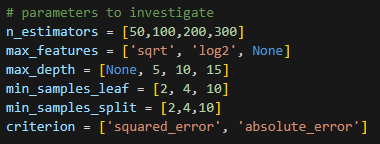


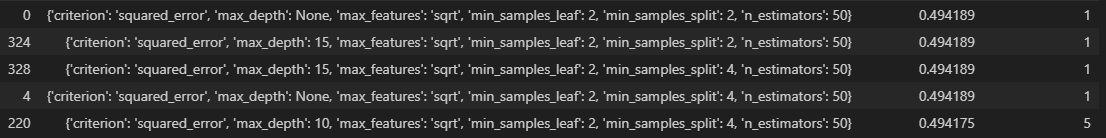

Looks like we should investigate fewer n_estimators and perhaps a higher max_depth (However, we should be aware of overfitting)

## 2nd iteration best results (exact same mean_test_error??):

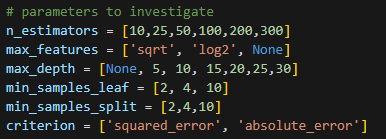

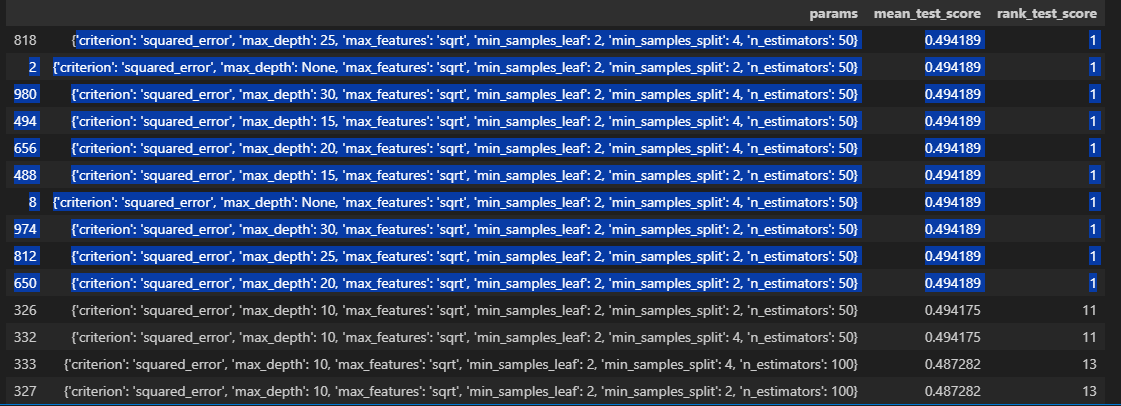


It looks like the max_depth is the most alternating parameter.
However, the investigation of the parameter is not that interesting...
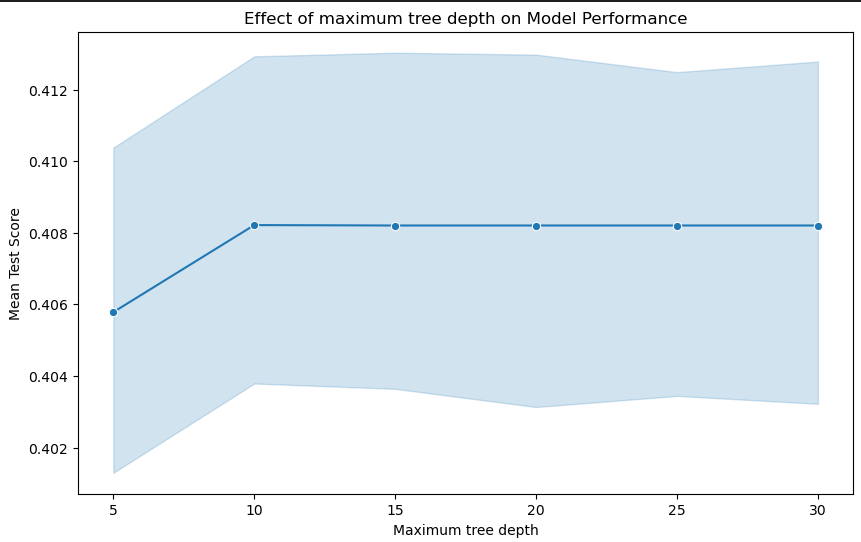

When we look at the performance (training vs. OOB):

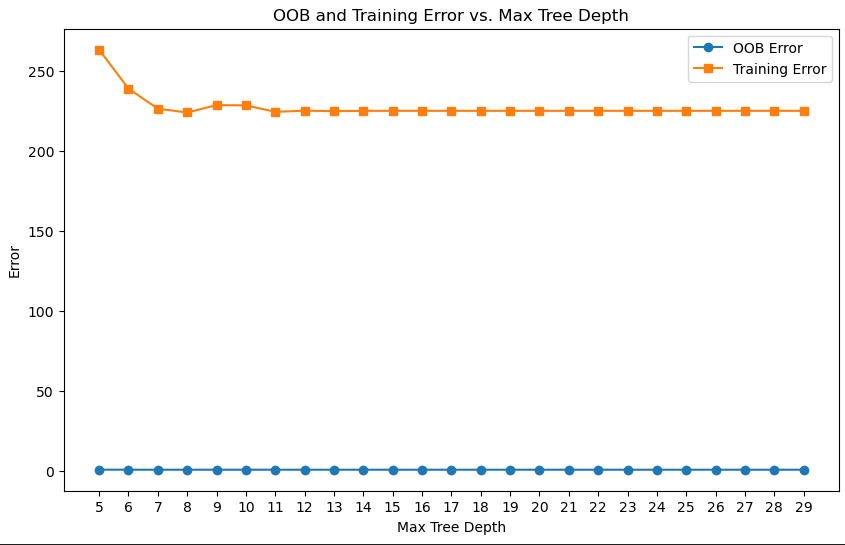

Which is not that exciting either...

# Code:

In [16]:
clf = RandomForestRegressor(random_state=0,oob_score=True)

# parameters to investigate
n_estimators = [10,25,50,100,200,300]
max_features = ['sqrt', 'log2', None]
max_depth = [None, 5, 10, 15,20,25,30]
min_samples_leaf = [2, 4, 10]
min_samples_split = [2,4,10]
criterion = ['squared_error', 'absolute_error']

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'criterion': criterion
}

# cv
rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid,cv =5,verbose=2,n_jobs=-1)

# fit grid search model
rf_grid.fit(imputed_df,y)

df_results = pd.DataFrame(rf_grid.cv_results_)

Fitting 5 folds for each of 2268 candidates, totalling 11340 fits


KeyboardInterrupt: 

In [ ]:
# Sort by rank or performance
df_sorted = df_results.sort_values(by=['rank_test_score'])

pd.set_option('display.max_colwidth', None)
df_sorted[['params', 'mean_test_score', 'rank_test_score']][:14]

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='param_max_depth', y='mean_test_score', marker='o')
plt.title('Effect of maximum tree depth on Model Performance')
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean Test Score')
plt.show()

In [ ]:
max_depth_range = np.arange(5, 30, 1)
oob_errors = []
training_errors = []

for depth in max_depth_range:
    model = RandomForestRegressor(n_estimators=50, max_depth=depth, oob_score=True, random_state=0)
    model.fit(imputed_df, y)
    
    # Record the OOB error
    oob_error = 1 - model.oob_score_
    oob_errors.append(oob_error)
    
    # Record the training error
    training_predictions = model.predict(imputed_df)
    training_error = np.mean((y - training_predictions) ** 2)  # MSE as the training error
    training_errors.append(training_error)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, oob_errors, label='OOB Error', marker='o')
plt.plot(max_depth_range, training_errors, label='Training Error', marker='s')
plt.xlabel('Max Tree Depth')
plt.ylabel('Error')
plt.title('OOB and Training Error vs. Max Tree Depth')
plt.legend()
plt.xticks(max_depth_range)
plt.show()

# Elastic net

In [65]:
y_elnet = preprocessing.StandardScaler().fit_transform(np.reshape(y.values, (-1,1)))

1.0

In [115]:
elnet = ElasticNetCV(cv=5, random_state=0) #l1_ratio=[.01,.05,.1, .5, .7, .9, .95, .99, 1]
elnet.fit(imputed_df, y_elnet.ravel())
print(elnet.alpha_)
print(elnet.intercept_)
print(elnet.l1_ratio_)
# print(regr.predict([[0, 0]]))


c:\Users\dkadpe\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.691e-03, tolerance: 7.936e-03



0.016527683510832447
-0.008420664710559127
0.5


In [121]:
pred = elnet.predict(imputed_df)

residual = y_elnet.ravel() - pred

In [122]:
elnet.score(imputed_df, y_elnet)

0.9572033016310538

In [123]:
rmse = np.sqrt(np.mean(np.square(residual)))
rmse

0.2068736289838466

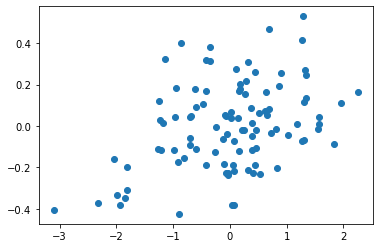

In [124]:
plt.scatter(y_elnet, residual)

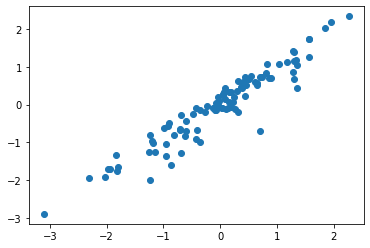

In [120]:
plt.scatter(y_elnet, pred)